In [27]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random

DATA_PATH = Path("../data/processed/snippets.npz")
SNIPPETS_PATH = Path("../data/processed/snippets.npz")

In [8]:
# ---------------------
# Dataset & utilities
# ---------------------

class MelodySnippetsDataset(Dataset):
    def __init__(self, intervals, indices):
        """
        intervals: np.ndarray of shape (N, L)
        indices: np.ndarray of snippet indices to use for this split
        """
        self.intervals = intervals
        self.indices = np.array(indices, dtype=int)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        seq = self.intervals[i]  # shape (L,)
        # return as tensor of token ids
        return torch.tensor(seq, dtype=torch.long)


def load_data_and_build_vocab(data_path=DATA_PATH):
    data = np.load(data_path, allow_pickle=True)
    intervals = data["intervals"]  # (N, L)
    song_ids = data["song_ids"]
    # durations = data["durations"]  # not used yet
    midi_filenames = data.get("midi_filenames", None)

    # Map raw interval values (can be negative) to token ids [0..V-1]
    min_interval = intervals.min()
    max_interval = intervals.max()
    shifted_intervals = intervals - min_interval  # now in [0..(max-min)]

    vocab_size = int(max_interval - min_interval + 1)

    return shifted_intervals, song_ids, midi_filenames, min_interval, vocab_size


def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs = unique_songs[n_train:n_train + n_val]
    test_songs = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx = idx_for(val_songs)
    test_idx = idx_for(test_songs)

    return train_idx, val_idx, test_idx

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MelodyEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, proj_dim=64, num_layers=1):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # Project to final embedding dimension
        self.proj = nn.Linear(hidden_dim, proj_dim)

    def forward(self, x):
        """
        x: (B, L) token ids
        returns: (B, D) L2-normalized embedding
        """
        emb = self.token_embed(x)           # (B, L, E)
        _, h_n = self.encoder_rnn(emb)      # h_n: (num_layers, B, H)
        h_last = h_n[-1]                    # (B, H)
        z = self.proj(h_last)               # (B, D)
        z = F.normalize(z, dim=-1)          # L2-normalize for cosine similarity
        return z


In [10]:
from torch.utils.data import Dataset
import numpy as np
import random

class MelodyPairsDataset(Dataset):
    def __init__(self, intervals, song_ids, indices):
        """
        intervals: np.ndarray (N, L)
        song_ids: np.ndarray (N,)
        indices: subset of snippet indices to use for contrastive training
        """
        self.intervals = intervals
        self.song_ids = song_ids
        self.indices = np.array(indices, dtype=int)

        # Build mapping: song_id -> list of snippet indices (within global indexing)
        self.song_to_indices = {}
        for i in self.indices:
            sid = int(song_ids[i])
            self.song_to_indices.setdefault(sid, []).append(i)

        # Keep only anchors whose song has at least 2 snippets
        self.anchor_indices = []
        for sid, idxs in self.song_to_indices.items():
            if len(idxs) >= 2:
                self.anchor_indices.extend(idxs)

        self.anchor_indices = np.array(self.anchor_indices, dtype=int)
        print(f"MelodyPairsDataset: {len(self.anchor_indices)} anchor snippets "
              f"from {len(self.song_to_indices)} songs (only songs with >=2 snippets used).")

    def __len__(self):
        return len(self.anchor_indices)

    def __getitem__(self, idx):
        anchor_i = self.anchor_indices[idx]
        sid = int(self.song_ids[anchor_i])

        # choose a positive index from the same song, different snippet
        candidates = self.song_to_indices[sid]
        if len(candidates) < 2:
            # shouldn't happen due to filtering, but be safe
            pos_i = anchor_i
        else:
            pos_i = anchor_i
            while pos_i == anchor_i:
                pos_i = random.choice(candidates)

        anchor_seq = self.intervals[anchor_i]  # (L,)
        pos_seq = self.intervals[pos_i]        # (L,)

        return (
            torch.tensor(anchor_seq, dtype=torch.long),
            torch.tensor(pos_seq, dtype=torch.long),
        )


In [11]:
def contrastive_loss(z_a, z_p, temperature=0.1):
    """
    z_a: (B, D) anchor embeddings (L2-normalized)
    z_p: (B, D) positive embeddings (L2-normalized)
    Returns scalar loss.
    """
    B, D = z_a.shape

    # Cosine similarities: (B, B)
    sim_matrix = z_a @ z_p.T  # since vectors are normalized, this is cosine similarity

    # Scale by temperature
    logits = sim_matrix / temperature

    # For anchor->positive: correct positive for i is i
    labels = torch.arange(B, device=z_a.device)

    loss_a2p = F.cross_entropy(logits, labels)

    # Symmetric: positive->anchor
    loss_p2a = F.cross_entropy(logits.T, labels)

    loss = 0.5 * (loss_a2p + loss_p2a)
    return loss


In [12]:
from torch.utils.data import DataLoader
from pathlib import Path


CONTRASTIVE_EMBED_PATH = Path("../data/processed/contrastive_embeddings.npz")

def train_contrastive_encoder(
    batch_size=256,
    num_epochs=10,
    lr=1e-3,
    temperature=0.1,
    device=None,
):
    # Load data + vocab
    intervals, song_ids, midi_filenames, min_interval, vocab_size = load_data_and_build_vocab()

    # We will train contrastive encoder only on train songs
    train_idx, val_idx, test_idx = split_by_song(song_ids)
    print(f"Total snippets: {intervals.shape[0]}")
    print(f"Train/Val/Test sizes: {len(train_idx)}, {len(val_idx)}, {len(test_idx)}")
    print(f"Vocab size: {vocab_size}, min_interval={min_interval}")

    train_pairs_ds = MelodyPairsDataset(intervals, song_ids, train_idx)

    train_loader = DataLoader(
        train_pairs_ds,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,  # make batches aligned for contrastive loss
    )

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = MelodyEncoder(vocab_size=vocab_size, embed_dim=64, hidden_dim=128, proj_dim=64)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch_losses = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            anchors, positives = batch  # each: (B, L)
            anchors = anchors.to(device)
            positives = positives.to(device)

            optimizer.zero_grad()
            z_a = model(anchors)    # (B, D)
            z_p = model(positives)  # (B, D)

            loss = contrastive_loss(z_a, z_p, temperature=temperature)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / max(n_batches, 1)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch:02d} | contrastive_loss={avg_loss:.4f}")

    # After training, compute embeddings for ALL snippets (train+val+test)
    model.eval()
    all_embeddings = []

    full_ds = MelodySnippetsDataset(intervals, np.arange(intervals.shape[0]))
    full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in full_loader:
            batch = batch.to(device)
            z = model(batch)  # (B, D)
            all_embeddings.append(z.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)  # (N, D)
    print("All contrastive embeddings shape:", all_embeddings.shape)

    CONTRASTIVE_EMBED_PATH.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        CONTRASTIVE_EMBED_PATH,
        embeddings=all_embeddings,
        song_ids=song_ids,
        min_interval=min_interval,
        vocab_size=vocab_size,
        midi_filenames=midi_filenames,
    )
    print(f"Saved contrastive embeddings to {CONTRASTIVE_EMBED_PATH}")

    return {
        "train_idx": train_idx,
        "val_idx": val_idx,
        "test_idx": test_idx,
        "epoch_losses": epoch_losses,
    }


Total snippets: 35878
Train/Val/Test sizes: 24902, 5346, 5630
Vocab size: 184, min_interval=-94
MelodyPairsDataset: 24896 anchor snippets from 626 songs (only songs with >=2 snippets used).
Using device: cuda
Epoch 01 | contrastive_loss=4.9812
Epoch 02 | contrastive_loss=4.3198
Epoch 03 | contrastive_loss=4.0728
Epoch 04 | contrastive_loss=3.9093
Epoch 05 | contrastive_loss=3.7882
Epoch 06 | contrastive_loss=3.6709
Epoch 07 | contrastive_loss=3.5820
Epoch 08 | contrastive_loss=3.4834
Epoch 09 | contrastive_loss=3.3929
Epoch 10 | contrastive_loss=3.2967
Epoch 11 | contrastive_loss=3.2034
Epoch 12 | contrastive_loss=3.0996
Epoch 13 | contrastive_loss=3.0081
Epoch 14 | contrastive_loss=2.9301
Epoch 15 | contrastive_loss=2.8714
Epoch 16 | contrastive_loss=2.7855
Epoch 17 | contrastive_loss=2.7021
Epoch 18 | contrastive_loss=2.6375
Epoch 19 | contrastive_loss=2.5678
Epoch 20 | contrastive_loss=2.5040
Epoch 21 | contrastive_loss=2.4506
Epoch 22 | contrastive_loss=2.3970
Epoch 23 | contrastiv

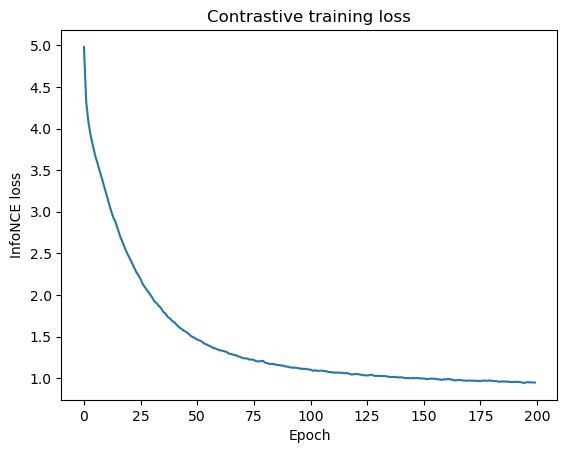

In [14]:
info_contrastive = train_contrastive_encoder(
    batch_size=256,
    num_epochs=200,
    lr=1e-3,
    temperature=0.1,
)

import matplotlib.pyplot as plt

plt.plot(info_contrastive["epoch_losses"])
plt.title("Contrastive training loss")
plt.xlabel("Epoch")
plt.ylabel("InfoNCE loss")
plt.show()
